In [1]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import cross_val_score
from pythainlp.corpus.common import thai_stopwords
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2,f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,accuracy_score
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('mari_dataset.csv')

In [3]:
def clean_text(txt):
    
    
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    txt = re.sub(r'<.@*?!>','', txt)
    
    # ลบ hashtag
    txt = re.sub(r'#','',txt)

    # ลบ space
    txt = re.sub(r' ','',txt)
    
    #ลบ เลข
    txt = re.sub("(\d)", "",txt)
    
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        txt = re.sub(r'\{}'.format(c),'',txt)
    
    # ลบ separator เช่น \n \t
    txt = ' '.join(txt.split())

    
    return txt

def tokenize(txt):
    space =[]
    for i in txt:
        space.append(i)
    return space

df.text = df.text.apply(clean_text)

In [4]:
test_frac = round(0.1*(df.shape[0]))
train_df = df[:-(test_frac)]
test_df = df[-(test_frac):]

In [6]:
x_train = train_df['text']
y_train = train_df['label']

x_test = test_df['text']
y_test = test_df['label']

In [14]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(np.array(x_train).reshape(-1, 1), y_train)

In [35]:
vectorizer = TfidfVectorizer(min_df=10, 
                             max_df=0.5, 
                             sublinear_tf=True, 
                             ngram_range=(2,7), 
                             tokenizer=tokenize)

In [36]:
x_train_ = vectorizer.fit_transform(x_train)
x_test_ = vectorizer.transform(x_test)
# x_train_ = vectorizer.fit_transform(pd.Series(X_over.flatten()))
# x_test_ = vectorizer.transform(x_test)

In [37]:
selector = SelectKBest(score_func=chi2, k=9000)

In [38]:
x_train__ = selector.fit_transform(x_train_, y_train)
x_test__ = selector.transform(x_test_)
# x_train__ = selector.fit_transform(x_train_, y_over)
# x_test__ = selector.transform(x_test_)

In [39]:
model = StackingClassifier([('svm', LinearSVC(random_state=4)), 
                            ('log_reg', LogisticRegression(random_state=4)), 
                            ('knn', KNeighborsClassifier(n_neighbors=14)),
                            ('trees', RandomForestClassifier(max_depth=40, 
                                                             random_state=4))], 
                           final_estimator=LogisticRegression(random_state=4), 
                           n_jobs=-1)
model.fit(x_train__, y_train).score(x_test__, y_test)
#model.fit(x_train__, y_over).score(x_test__, y_test)

0.856727976766699

In [32]:

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
           ('vect', TfidfVectorizer(
                             sublinear_tf=True, 
                             ngram_range=(2, 7), 
                             tokenizer=tokenize)),
           ('select', SelectKBest(score_func=chi2,k=9000)),
           ('clf', model),
])
parameters = [{
    'vect__max_df': (0.5, 0.6, 0.7),
    'vect__min_df': (7,8,9,10,11),
#     'select__k': (7000,8000,9000)
#     'vect__max_features': (None, 5000, 10000, 50000),
#     'vect__ngram_range': ((1, 1), (1, 2), (1,3)),  
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2', None),
}]

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3)
grid_search.fit(x_train, y_train).score(x_test, y_test)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


0.8576960309777347

In [33]:
result = pd.DataFrame(grid_search.cv_results_)

In [35]:
result.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__max_df,param_vect__min_df,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,93.782213,2.100280,2.921141,0.146865,0.5,10,"{'vect__max_df': 0.5, 'vect__min_df': 10}",0.850457,0.846154,0.842926,0.849381,0.832168,0.844217,0.006576,1
8,88.385002,0.990728,2.721353,0.096758,0.6,10,"{'vect__max_df': 0.6, 'vect__min_df': 10}",0.850457,0.846154,0.842926,0.849381,0.832168,0.844217,0.006576,1
13,89.493360,1.009133,3.163745,0.227700,0.7,10,"{'vect__max_df': 0.7, 'vect__min_df': 10}",0.850457,0.846154,0.842926,0.849381,0.832168,0.844217,0.006576,1
2,90.818449,0.975389,2.960148,0.098199,0.5,9,"{'vect__max_df': 0.5, 'vect__min_df': 9}",0.849919,0.847230,0.842926,0.847768,0.831092,0.843787,0.006741,4
7,91.626409,1.329975,3.289257,0.349160,0.6,9,"{'vect__max_df': 0.6, 'vect__min_df': 9}",0.849919,0.847230,0.842926,0.847768,0.831092,0.843787,0.006741,4
12,88.133371,0.715525,3.514521,0.535876,0.7,9,"{'vect__max_df': 0.7, 'vect__min_df': 9}",0.849919,0.847230,0.842926,0.847768,0.831092,0.843787,0.006741,4
1,83.391189,4.417169,2.798855,0.187973,0.5,8,"{'vect__max_df': 0.5, 'vect__min_df': 8}",0.849381,0.845078,0.845616,0.844540,0.831092,0.843141,0.006260,7
6,90.896683,2.403295,3.013716,0.555241,0.6,8,"{'vect__max_df': 0.6, 'vect__min_df': 8}",0.849381,0.845078,0.845616,0.844540,0.831092,0.843141,0.006260,7
11,86.032985,0.370934,2.963332,0.624865,0.7,8,"{'vect__max_df': 0.7, 'vect__min_df': 8}",0.849381,0.845078,0.845616,0.844540,0.831092,0.843141,0.006260,7
0,80.238670,1.413846,2.699684,0.146514,0.5,7,"{'vect__max_df': 0.5, 'vect__min_df': 7}",0.846154,0.845616,0.842388,0.847230,0.831630,0.842604,0.005719,10


In [75]:
grid_search.best_estimator_.score(x_test, y_test)

0.8576960309777347

In [78]:
scores = cross_val_score(
model, x_train__, y_train, cv=5, scoring='f1_macro')
print(scores)

array([0.85612193, 0.85925505, 0.85085555, 0.8738534 , 0.85821883])

In [98]:
y_test_pred = model.predict(x_test__)

print(classification_report(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

                       precision    recall  f1-score   support

  billing and payment       0.88      0.89      0.89       389
international dialing       0.90      0.88      0.89        41
             internet       0.82      0.79      0.80       164
      lost and stolen       1.00      0.93      0.97        15
        other queries       0.82      0.82      0.82       183
           promotions       0.85      0.88      0.87       225
           true money       1.00      0.81      0.90        16

             accuracy                           0.86      1033
            macro avg       0.90      0.86      0.87      1033
         weighted avg       0.86      0.86      0.86      1033

0.8576960309777347


<function matplotlib.pyplot.show(*args, **kw)>

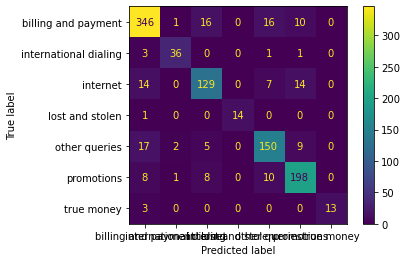

In [102]:
import matplotlib
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, x_test__, y_test)
plt.show